In [122]:
import math, functools, time
import numpy as np
import torch
import torch.distributions as tdist
import gpytorch
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from gpytorch.kernels import GridInterpolationKernel as SKI


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
def timeit(fun):
    @functools.wraps(fun)
    def wrapped(*args, **kwargs):
        start = time.time()
        res = fun(*args, **kwargs)
        print(f"taking {time.time() - start}s")
        return res
    return wrapped

@timeit
def eval_ker(ker, data):
    return ker(data).evaluate().detach().numpy()

def plot_ker(kern_mat, title=None):
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    fig, ax = plt.subplots(sharey=True)
    im = ax.imshow(kern_mat)
    fig.colorbar(im, format=ticker.FuncFormatter(fmt))
    ax.set_title(title)
    plt.show()

taking 0.008512020111083984s


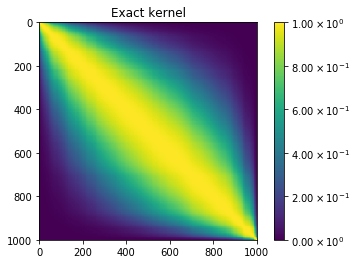

In [116]:
# train data
train_x = tdist.Normal(torch.tensor([0.]), torch.tensor([25.])).sample((1000, )).squeeze()
train_x = train_x.sort()[0]

# exact kernel and approx(Structured Kernel Interpolations)
rbf = gpytorch.kernels.RBFKernel()
rbf.lengthscale = torch.tensor(20.) 
grid_sizes = [20,40,100,200,400,1000]
skis = {m:SKI(rbf, grid_size=m, num_dims=1) for m in grid_sizes}
ski_cov_mats = {}
# plot the exact kernel
true_cov_mat = eval_ker(rbf, train_x)
plot_ker(true_cov_mat, title=f"Exact kernel")

taking 0.07941102981567383s


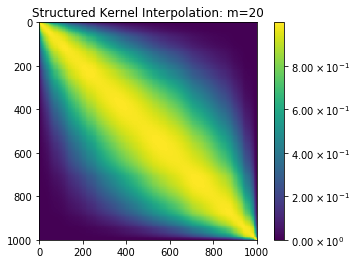

taking 0.045977115631103516s


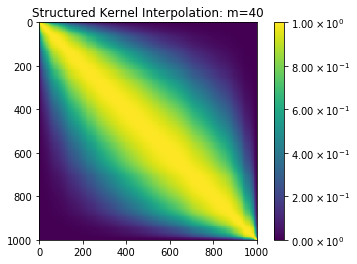

taking 0.06055903434753418s


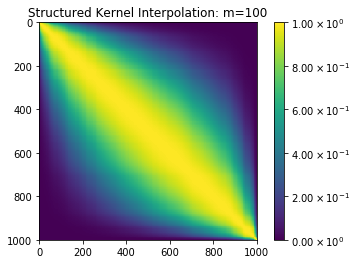

taking 0.05278277397155762s


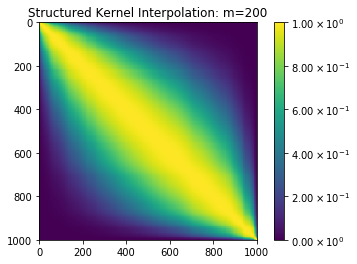

taking 0.07883596420288086s


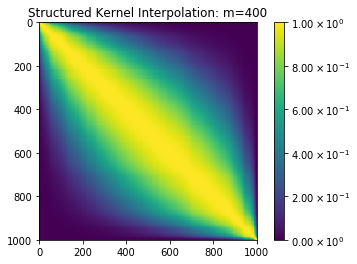

taking 0.10835623741149902s


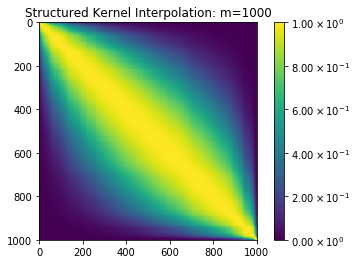

In [118]:
# plot the approx kernels
for m in grid_sizes:
    ski = skis[m]
    ski_cov_mat = eval_ker(ski, train_x)
    ski_cov_mats[m] = ski_cov_mat
    plot_ker(ski_cov_mat, title=f"Structured Kernel Interpolation: m={m}")

 now we compare the $l_2$-norm of the difference between apporx kernel and exact kernel based on the grid size $m$

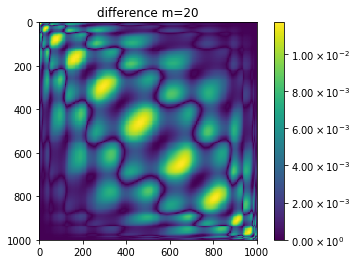

Difference in l-2 norm: 2.8576717376708984, infinity norm: 0.011692702770233154


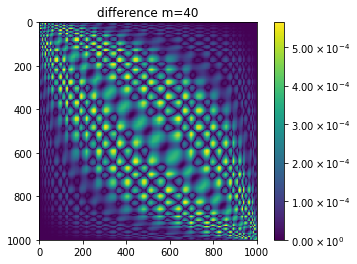

Difference in l-2 norm: 0.11952301859855652, infinity norm: 0.0005644559860229492


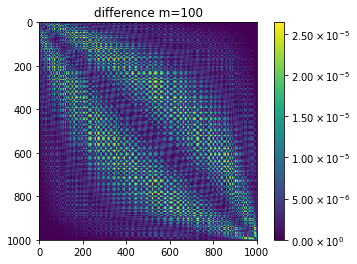

Difference in l-2 norm: 0.004344836808741093, infinity norm: 2.6404857635498047e-05


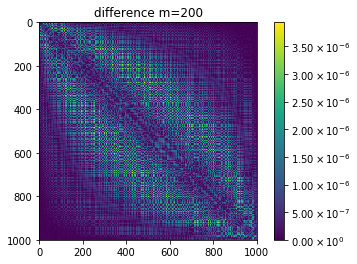

Difference in l-2 norm: 0.0004927439731545746, infinity norm: 3.933906555175781e-06


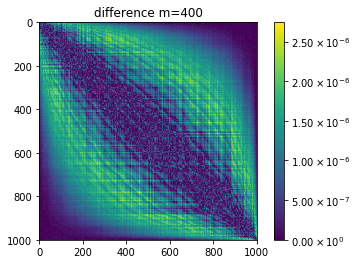

Difference in l-2 norm: 0.0009163067443296313, infinity norm: 2.7418136596679688e-06


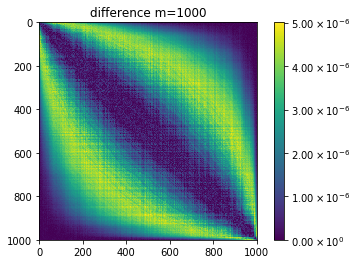

Difference in l-2 norm: 0.0021922606974840164, infinity norm: 5.0067901611328125e-06


In [119]:
# l2-norm drop in the difference
l2_diffs = {}
linf_diffs = {}
for m in grid_sizes:
    ski_cov_mat = ski_cov_mats[m]
    diff = true_cov_mat - ski_cov_mat
    plot_ker(np.abs(diff), title=f"difference m={m}")
    l2_diff = np.linalg.norm(diff, 2); l2_diffs[m] = l2_diff
    linf_diff = np.max(np.abs(diff)); linf_diffs[m] = linf_diff
    print(f"Difference in l-2 norm: {l2_diff}, infinity norm: {linf_diff}")

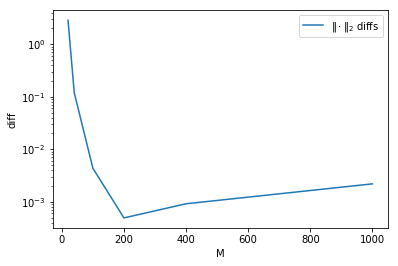

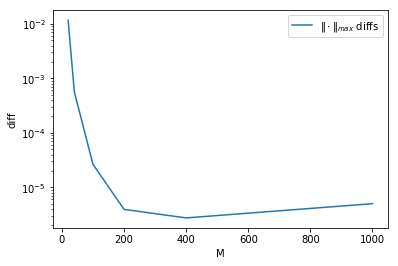

In [121]:
plt.yscale("log")
plt.ylabel("diff")
plt.xlabel("M")
plt.plot(grid_sizes, [l2_diffs[m] for m in grid_sizes])
plt.legend(["$\Vert \cdot \Vert_2$ diffs"])
plt.show()

plt.yscale("log")
plt.ylabel("diff")
plt.xlabel("M")
plt.plot(grid_sizes, [linf_diffs[m] for m in grid_sizes])
plt.legend(["$\Vert \cdot \Vert_{max}$ diffs"])
plt.show()